# Packages setup and imports

In [7]:
!pip install pandas
!pip install nltk
!pip install langdetect
!pip install gensim
!pip install matplotlib
!pip install wordcloud

In [19]:
import csv
from gensim.models import LdaModel
from gensim import corpora
import glob
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import itertools
import operator 
import os
import pandas as pd
import string
import re
from wordcloud import WordCloud, STOPWORDS

import langdetect
from langdetect import detect

from tokenize import tokenize

In [153]:
#NLTK packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
nltk.download('omw-1.4')  
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import MLEProbDist

stop_words = stopwords.words('english')
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
# Set up the file paths and directory names
restaurant_reviews_csv = r"./scraped_data/TripAdvisor_restaurants_reviews.csv"
restaurant_reviews_cleaned_csv = r"./scraped_data/TripAdvisor_restaurants_reviews_cleaned.csv"
restaurant_info_csv = r"./scraped_data/TripAdvisor_restaurants.csv"
folder_name = "reviews"

# Preprocessing

Requires only to be ran once to obtain _TripAdvisor\_restaurants\_reviews\_cleaned.csv_ and to separate reviews into different files according to the restaurant type.

* Removing duplicate reviews and writing to new file;
* Processing reviews to identify which restaurant types are the most common in the scraped reviews;
* Separate reviews to the separate files based on the type of the restaurants and based on the customer satiscation.

In [99]:
def remove_duplicates(file_path, processed_file_path):
    columns = ["Restaurant name", "Author", "Date", "Review", "Rating"]
    data = pd.read_csv(file_path,names=columns)
    duplicateRowsDF = data[data['Review'].duplicated()]
    print("Found duplicates: " + str(len(duplicateRowsDF)) + ". Removing and writing to new file.")
    cleaned_df = data.drop_duplicates(subset="Review")
    cleaned_df = remove_non_english_reviews(cleaned_df)
    cleaned_df.to_csv(processed_file_path, columns=columns, index=False)

def remove_non_english_reviews(dataframe):
    rows_to_remove = []
    for i, df_row in dataframe.iterrows():
        language = ""
        try:
            language = detect(df_row["Review"])
        except:
            print("Language was not identified, skipping one review for the restaurant " + str(df_row["Restaurant name"]))
        if language != "en":
            rows_to_remove.append(i)
    dataframe = dataframe.drop(rows_to_remove)
    print("Removed " + str(len(rows_to_remove)) + " non-English reviews. Total number of reviews left: " + str(len(dataframe.index)))
    return dataframe

def get_dict_of_most_common_types_of_restaurants(file_path, k_top_keys = 5):
    with open(file_path, mode='r', newline='', encoding="utf-8") as restaurant_file:
        data_reader = csv.reader(restaurant_file, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
        type_restaurant_dictionary = {}
        type_count_dictionary = {}
        for (restaurant_name, _, types) in data_reader:
            for ty in types.strip('][').split(', '):
                if ty: #Check string not null or empty
                    lower_case_type = ty.lower().replace("'", "").replace(" ", "_")
                    if lower_case_type: 
                        if lower_case_type not in type_restaurant_dictionary.keys():
                            type_restaurant_dictionary[lower_case_type] = [restaurant_name]
                            type_count_dictionary[lower_case_type] = 1
                        else:
                            type_restaurant_dictionary[lower_case_type].append(restaurant_name)
                            type_count_dictionary[lower_case_type] += 1
        sorted_type_count_dictionary = dict(sorted(type_count_dictionary.items(), key=operator.itemgetter(1), reverse=True))
        top_keys = list(sorted_type_count_dictionary.keys())[:k_top_keys]
        result_dictionary = {}
        for key in top_keys:
            result_dictionary[key] = type_restaurant_dictionary[key]
        return result_dictionary
    
def separate_reviews_to_files(reviews_filepath, type_restaurant_dictionary, folder_name):
    all_restaurants_values = [x for xs in list(itertools.chain(type_restaurant_dictionary.values())) for x in xs]
    with open(reviews_filepath, mode='r', newline='', encoding="utf-8") as restaurant_file:
        data_reader = csv.reader(restaurant_file, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
        for (restaurant_name, author, date, review, rating) in data_reader:
            if restaurant_name in all_restaurants_values:
                keys_list = [k for k, v in type_restaurant_dictionary.items() if restaurant_name in v]
                for key in keys_list:
                    review = review.replace("\"", ""). replace("'", "")
                    if float(rating) > 3.0:
                        with open(fr"./{folder_name}/{key}_positive.csv", mode='a+', newline='', encoding="utf-8") as trip:
                            data_writer = csv.writer(trip, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
                            data_writer.writerow([review])
                    elif float(rating) <= 3.0:
                        with open(fr"./{folder_name}/{key}_negative.csv", mode='a+', newline='', encoding="utf-8") as trip:
                            data_writer = csv.writer(trip, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
                            data_writer.writerow([review])
                    else:
                        continue
                        #raise Exception('incorrect rating')

The following code removes duplicates from the data and separates data into files according to the most popular restaurants in the netherlands. 
The code should only be executed once, as there is no need to run it more times, but it is time consuming!

In [101]:
k_top_restaurant_types = 5
print("Process scraped reviews and replace reviews folder content.")
files_to_remove = glob.glob(f'./{folder_name}/*')
for f in files_to_remove:
    os.remove(f)
remove_duplicates(restaurant_reviews_csv, restaurant_reviews_cleaned_csv) # Removing duplicates
# Finding out what restaurant types are most common and returning dictionary {"restaurant type" : [list of restaurant names of the type]}
most_common_restaurants_dict = get_dict_of_most_common_types_of_restaurants(restaurant_info_csv, k_top_keys=k_top_restaurant_types) 
separate_reviews_to_files(restaurant_reviews_cleaned_csv, most_common_restaurants_dict, folder_name)
files_written = glob.glob(f'./{folder_name}/*')
print("The following files were saved: ")
for f in files_written:
    print(f)

Process scraped reviews and replace reviews folder content.
Found duplicates: 1707. Removing and writing to new file.
Language was not identified, skipping one review for the restaurant Kababjee
Language was not identified, skipping one review for the restaurant Beachclub 't Gorsje
Removed 7623 non-English reviews. Total number of reviews left: 16149
The following files were saved: 
./reviews\dutch_negative.csv
./reviews\dutch_positive.csv
./reviews\european_negative.csv
./reviews\european_positive.csv
./reviews\italian_negative.csv
./reviews\italian_positive.csv
./reviews\seafood_negative.csv
./reviews\seafood_positive.csv
./reviews\vegetarian_friendly_negative.csv
./reviews\vegetarian_friendly_positive.csv


# Helper functions

In [124]:
def filepath_to_string(file_path):
    path_and_name = file_path.rsplit('\\', 1)
    if len(path_and_name) == 2:
        file_name = path_and_name[1].rsplit('.', 1)[0]
        type_rating_split = file_name.rsplit('_', 1)
        if len(type_rating_split) == 2:
            return type_rating_split[0].replace("_", " ").capitalize() + " (" + type_rating_split[1] + ")"
        else:
            raise Exception('incorrect filepath')
    else:
        raise Exception('incorrect filepath')

In [190]:
stop_words.extend(["restaurant"])

def reviews_ngrams(reviews, n):
    all_tokens = []
    for review in reviews:
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review)
        tokens = [token for token in tokens if token not in stop_words]
        all_tokens.extend(tokens)
    
    bgs = nltk.ngrams(all_tokens, n)
    return nltk.FreqDist(bgs)

In [246]:
def authors_ngrams(authors, n):
    all_tokens = []
    for author in authors:
        tokens = nltk.tokenize.sent_tokenize(author)
        all_tokens.extend(tokens)
    
    bgs = nltk.ngrams(all_tokens, n)
    return nltk.FreqDist(bgs)

In [222]:
def plot_dist_as_cloud(reviews_ngrams, n, max_words):
    prob_dist = MLEProbDist(reviews_ngrams)
    visualisation_dict = {}
    for word_freq_tuple in reviews_ngrams:
        string = ' '.join(word_freq_tuple)
        visualisation_dict[string] = prob_dist.prob(word_freq_tuple)
    cloud = WordCloud(width=1000, height=500, max_words=max_words).generate_from_frequencies(visualisation_dict)
  
    plt.figure(figsize = (30,30))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    print(f"Wordcloud for {n}-grams with the set max_words argument to {max_words}.")

In [248]:
def print_and_plot_ngrams(reviews_ngrams, n, plot_cloud=True):
    print(f'Found {len(reviews_ngrams)} {n}-grams. Most common 25 {n}-grams:')
    most_common_ngrams = reviews_ngrams.most_common(25)
    for word_freq_tuple in most_common_ngrams:
      print(word_freq_tuple)
    if plot_cloud:
        plot_dist_as_cloud(reviews_ngrams, n, 50)

# Data exploration

In [224]:
# Load data for exploration
columns = ["Restaurant name", "Author", "Date", "Review", "Rating"]
data = pd.read_csv(restaurant_reviews_cleaned_csv,names=columns)

In [250]:
# Show authors that posted the most reviews on the restaurants.
n = 1 
most_frequent_authors = authors_ngrams(data["Author"], n)
print_and_plot_ngrams(most_frequent_authors, n, False)

Found 10825 1-grams. Most common 25 1-grams:
(('susi492',), 61)
(('Henk M',), 54)
(('cyn505',), 47)
(('Hermes_NL',), 42)
(('WorldTravelOne',), 42)
(('Jussara Nunes P',), 32)
(('MaxPeen',), 30)
(('500dank',), 28)
(('Solodam J',), 23)
(('Fvbokhhorst',), 22)
(('HermesseJames',), 21)
(('DeKokkies',), 19)
(('Venneper',), 19)
(('301lisa33',), 19)
(('gillissg',), 19)
(('LA_Laldy',), 18)
(('Ronaldo070',), 18)
(('TRIPSPJLEE',), 17)
(('AS145',), 17)
(('Jan Peter d',), 17)
(('Rein-Gourmand',), 17)
(('mslotman',), 17)
(('Katy845',), 16)
(('Moonbeam666',), 15)
(('RUTHANDPAULLondon',), 15)


Found 20699 1-grams. Most common 25 1-grams:
(('food',), 8725)
(('good',), 8015)
(('service',), 5107)
(('nice',), 5060)
(('great',), 4499)
(('place',), 4273)
(('friendly',), 3726)
(('staff',), 3324)
(('menu',), 3021)
(('dinner',), 2148)
(('excellent',), 2119)
(('really',), 2090)
(('well',), 2057)
(('one',), 2032)
(('also',), 2006)
(('time',), 1981)
(('lunch',), 1818)
(('dishes',), 1690)
(('quality',), 1647)
(('us',), 1647)
(('delicious',), 1617)
(('go',), 1582)
(('would',), 1490)
(('atmosphere',), 1483)
(('back',), 1439)
Wordcloud for 1-grams with the set max_words argument to 50.


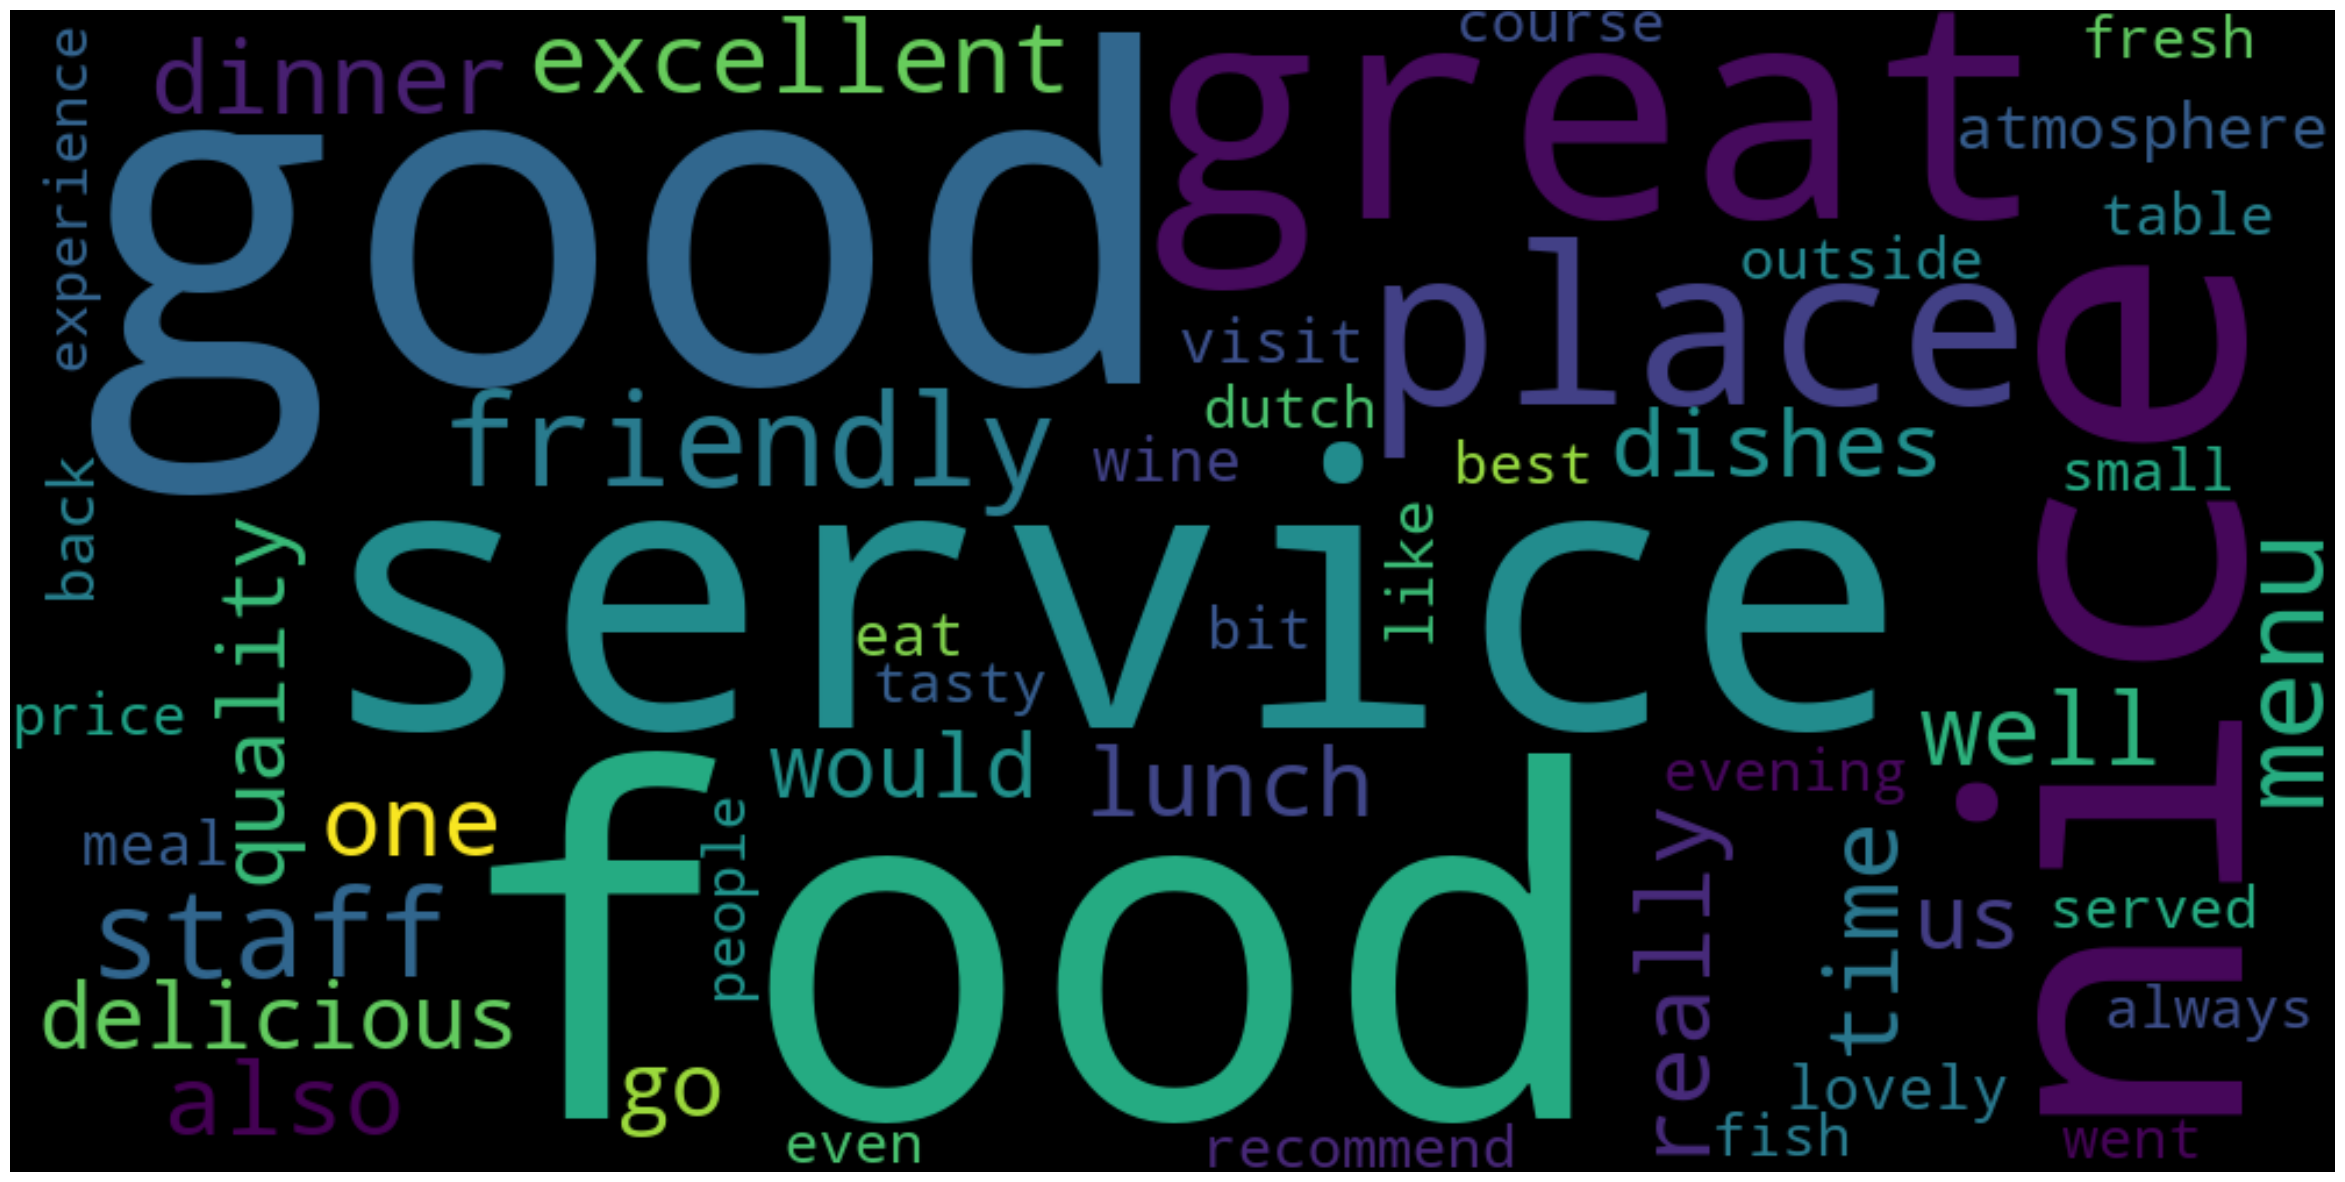

In [251]:
n = 1 
all_ngrams_frequencies = reviews_ngrams(data["Review"], n)
print_and_plot_ngrams(all_ngrams_frequencies, n)

Found 237969 2-grams. Most commong 25 2-grams:
(('food', 'good'), 788)
(('good', 'food'), 765)
(('friendly', 'staff'), 625)
(('staff', 'friendly'), 612)
(('good', 'service'), 519)
(('service', 'good'), 443)
(('friendly', 'service'), 414)
(('great', 'food'), 403)
(('ice', 'cream'), 394)
(('food', 'great'), 362)
(('service', 'friendly'), 362)
(('nice', 'place'), 349)
(('really', 'good'), 342)
(('come', 'back'), 336)
(('quality', 'food'), 329)
(('great', 'place'), 308)
(('food', 'excellent'), 299)
(('great', 'service'), 288)
(('good', 'quality'), 286)
(('main', 'course'), 257)
(('really', 'nice'), 254)
(('highly', 'recommended'), 246)
(('food', 'service'), 245)
(('go', 'back'), 244)
(('value', 'money'), 243)
Wordcloud for 2-grams with the set max_words argument to 50.


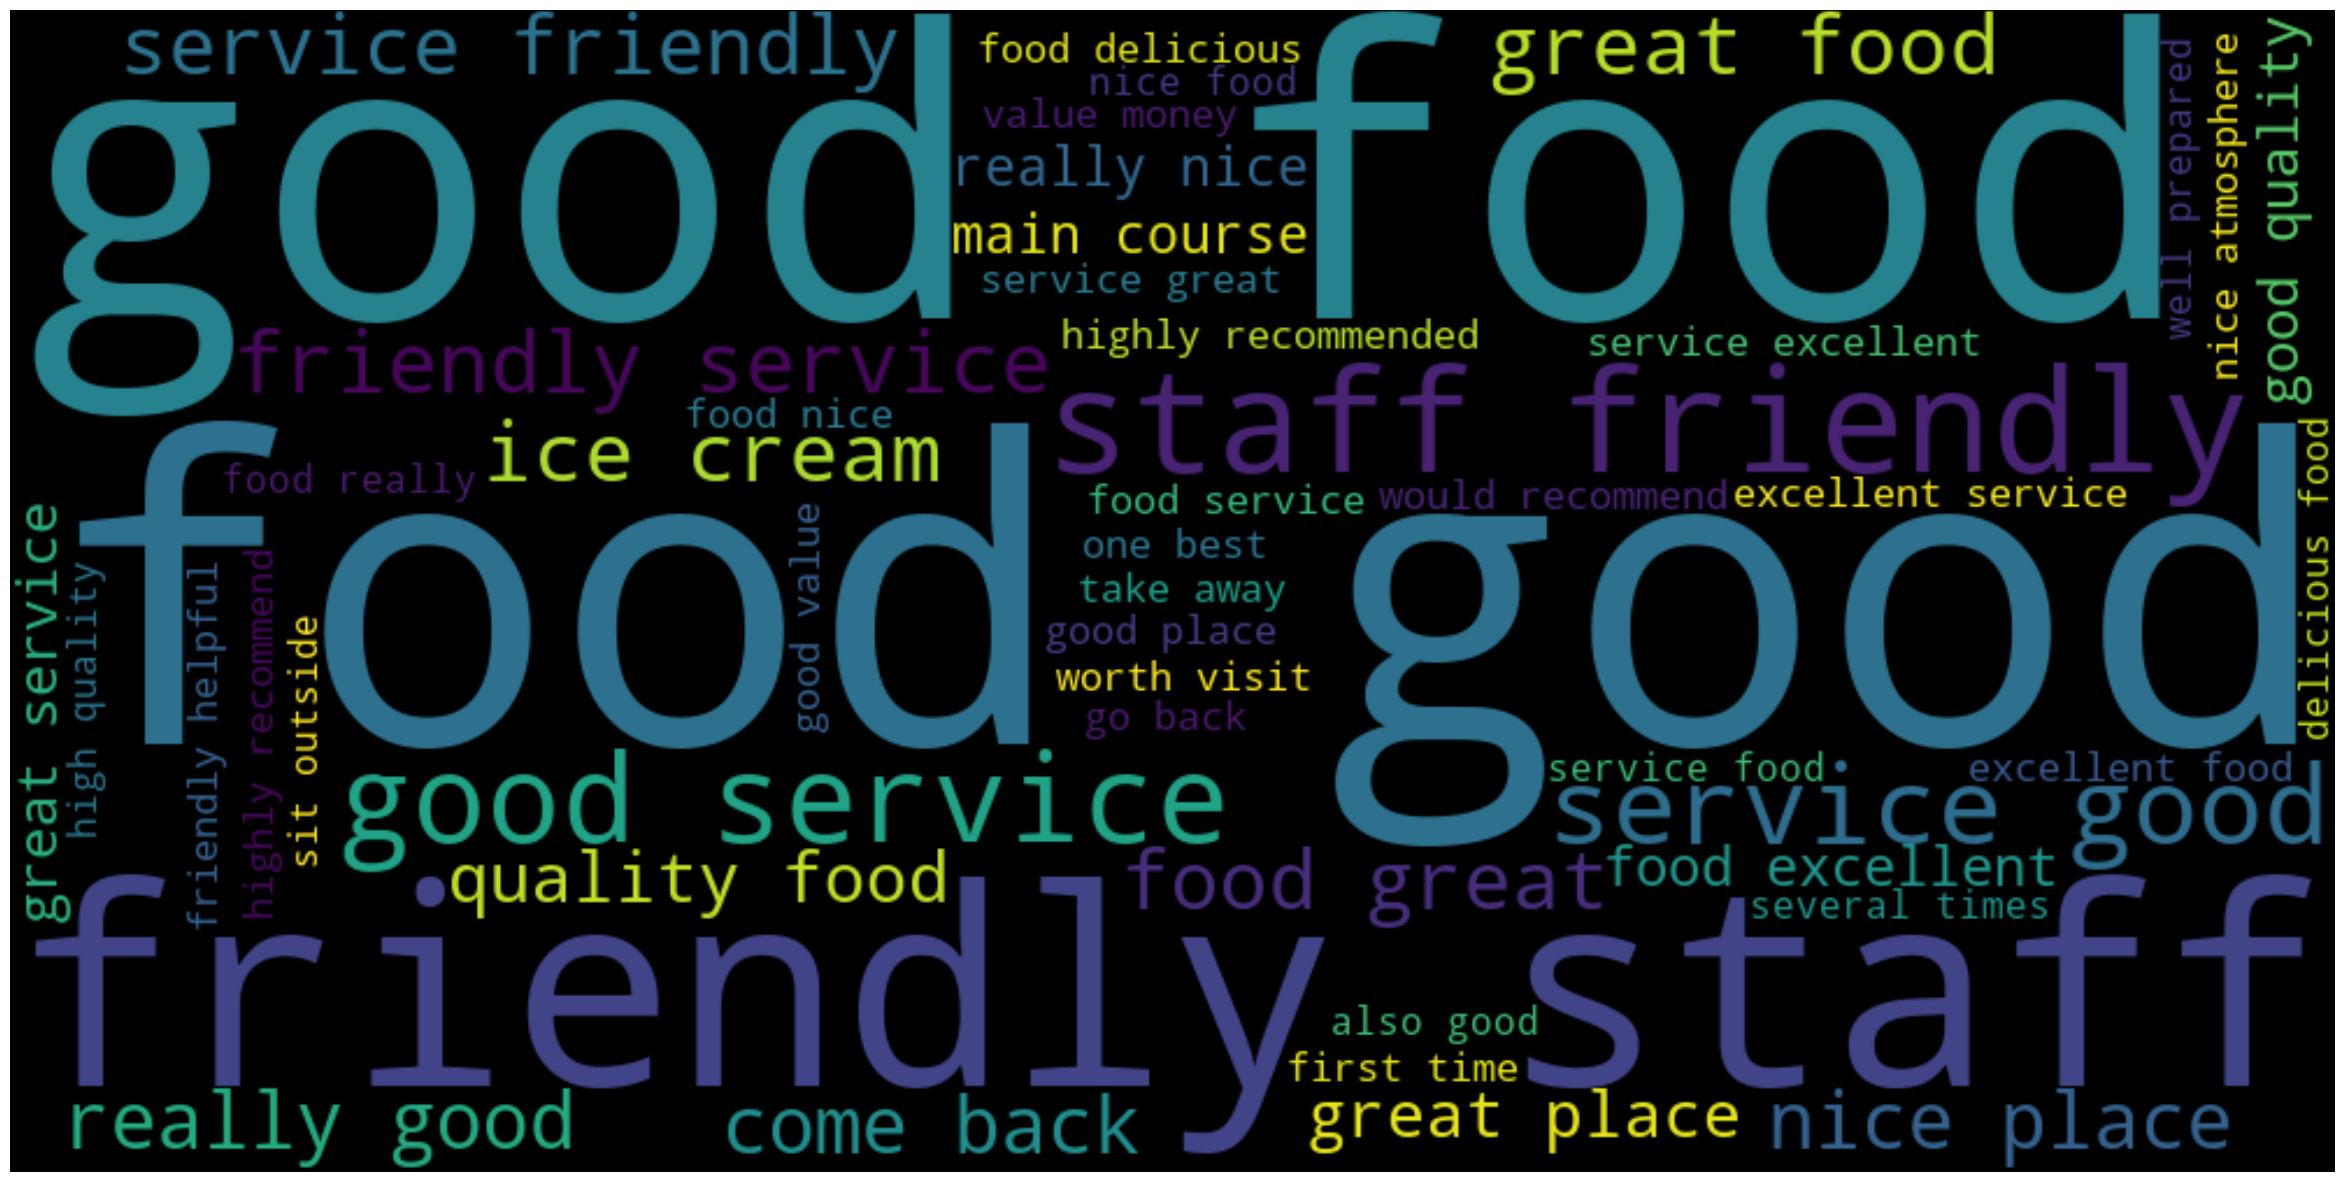

In [226]:
n = 2 
all_ngrams_frequencies = reviews_ngrams(data["Review"], n)
print_and_plot_ngrams(all_ngrams_frequencies, n)

Found 374334 3-grams. Most common 25 3-grams:
(('food', 'good', 'service'), 109)
(('good', 'value', 'money'), 89)
(('service', 'good', 'food'), 81)
(('van', 'der', 'valk'), 79)
(('good', 'food', 'good'), 70)
(('would', 'definitely', 'recommend'), 68)
(('staff', 'friendly', 'helpful'), 68)
(('friendly', 'staff', 'good'), 67)
(('food', 'great', 'service'), 65)
(('well', 'worth', 'visit'), 65)
(('food', 'really', 'good'), 62)
(('good', 'food', 'nice'), 56)
(('good', 'quality', 'food'), 52)
(('staff', 'friendly', 'food'), 51)
(('food', 'excellent', 'service'), 51)
(('service', 'great', 'food'), 50)
(('definitely', 'come', 'back'), 48)
(('would', 'highly', 'recommend'), 48)
(('good', 'service', 'friendly'), 48)
(('food', 'friendly', 'staff'), 47)
(('definitely', 'go', 'back'), 45)
(('good', 'staff', 'friendly'), 44)
(('friendly', 'service', 'good'), 42)
(('3', 'course', 'menu'), 41)
(('service', 'excellent', 'food'), 41)
Wordcloud for 3-grams with the set max_words argument to 50.


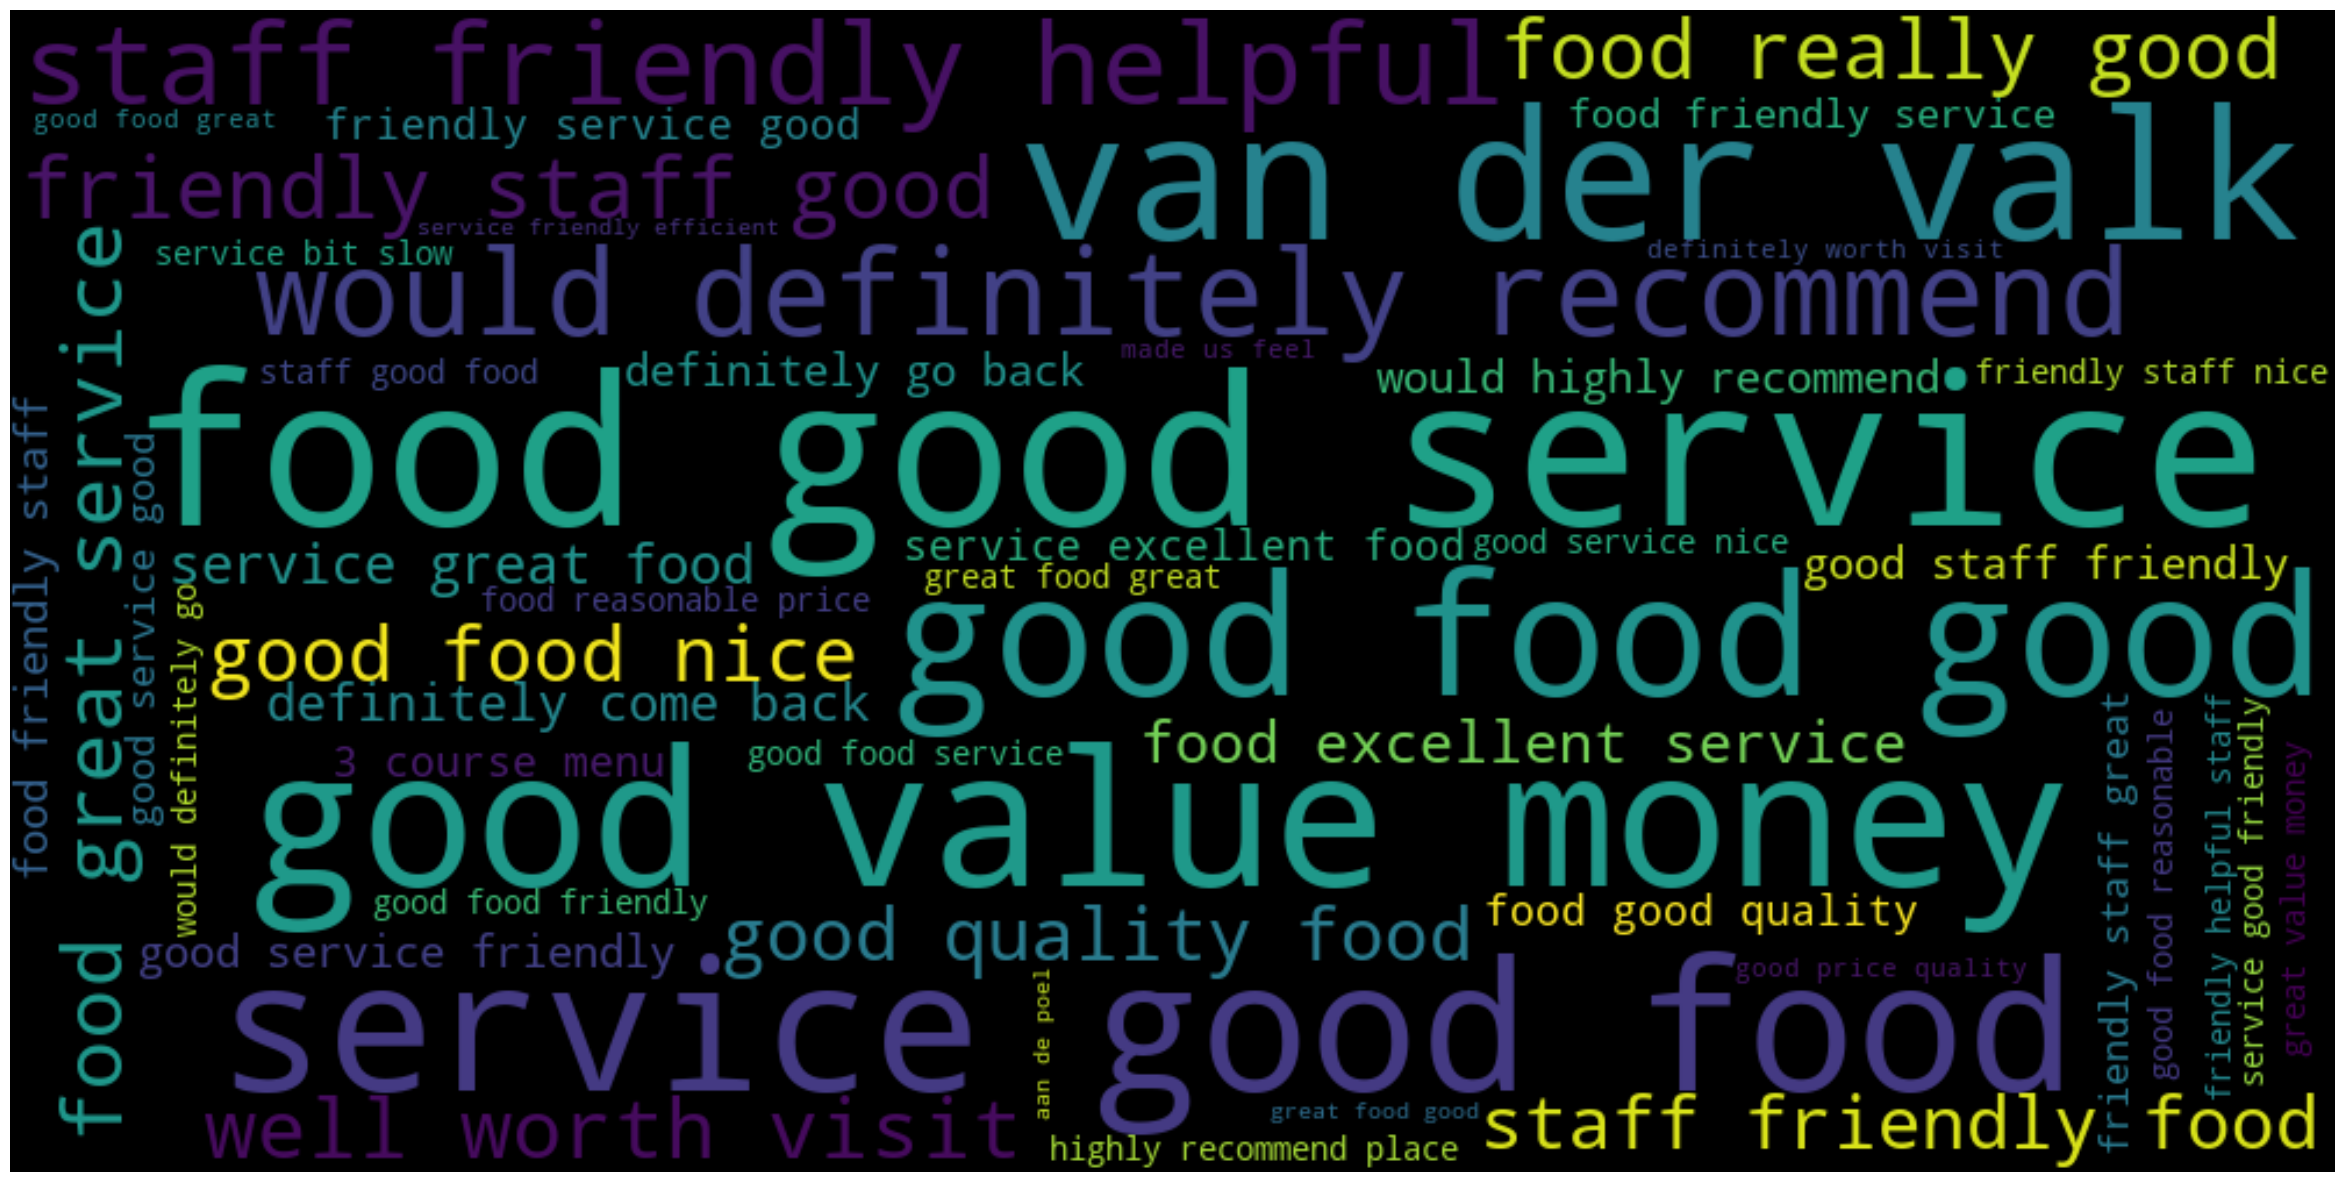

In [252]:
n = 3 
all_ngrams_frequencies = reviews_ngrams(data["Review"], n)
print_and_plot_ngrams(all_ngrams_frequencies, n)

# Topic modelling

In [253]:
# https://www.datacamp.com/tutorial/what-is-topic-modeling?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720818&utm_adgroupid=157156373991&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=683184494156&utm_targetid=aud-517318241987:dsa-2218886984380&utm_loc_interest_ms=&utm_loc_physical_ms=9061552&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-eu_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na-dec23&gad_source=1&gclid=Cj0KCQiA1rSsBhDHARIsANB4EJZ-QZC0xEcsPF2fT0cluyTpxUXictSMIjqg11H3y7ZUMMunehnrxjMaAnO6EALw_wcB
def read_and_preprocess_file(file_path):
    reviews = []
    with open(file_path, mode='r', newline='', encoding="utf-8") as reviews_file:
        data_reader = csv.reader(reviews_file, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
        for review_list in data_reader:
            review = review_list[0]
            stop_free = " ".join([i for i in review.lower().split() if i not in stop_words])
            punc_free = "".join(ch for ch in stop_free if ch not in exclude)
            normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
            reviews.append(normalized)
    return reviews

In [254]:
def topic_modelling(sentences_list, file_name):
    clean_corpus = [sentence.split() for sentence in sentences_list]
    dictionary = corpora.Dictionary(clean_corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_corpus]
    lda = LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary)
    num_topics = 10
    print(lda.print_topics(num_topics=num_topics, num_words=1))
    cols = [color for _, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
    topics = lda.show_topics(formatted=False)
    fig, axs = plt.subplots(1,len(topics), figsize=(15,10))
    axs = axs.ravel()
    for i in range(len(topics)):
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        axs[i].imshow(cloud)
        axs[i].set_title('Topic ' + str(i), fontdict=dict(size=16))
        axs[i].axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    print("Figure 1: Topic modelling for file " + filepath_to_string(file_name))

[(0, '0.018*"food"'), (1, '0.016*"food"'), (2, '0.013*"food"')]


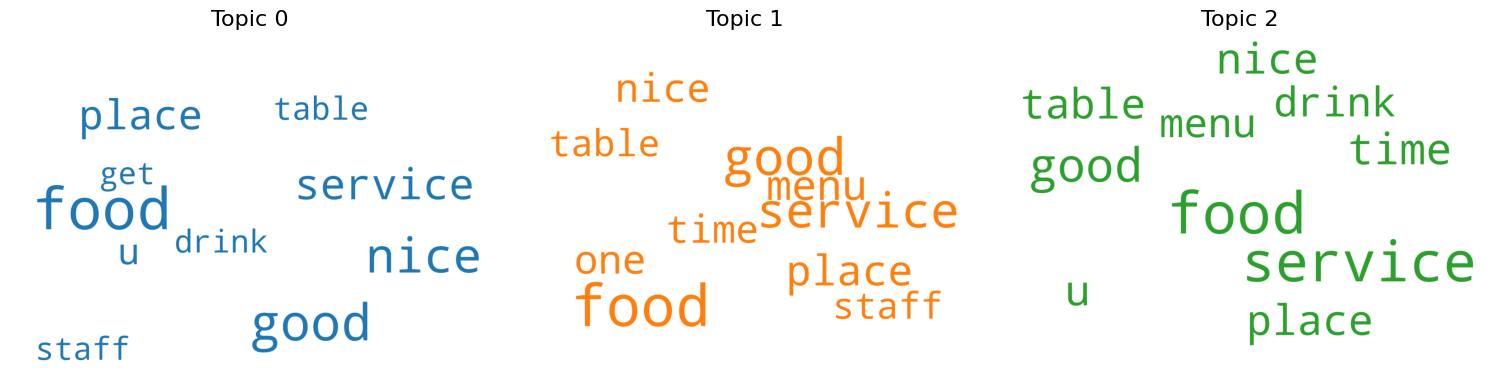

Figure 1: Topic modelling for file Dutch (negative)
[(0, '0.013*"food"'), (1, '0.030*"good"'), (2, '0.019*"food"')]


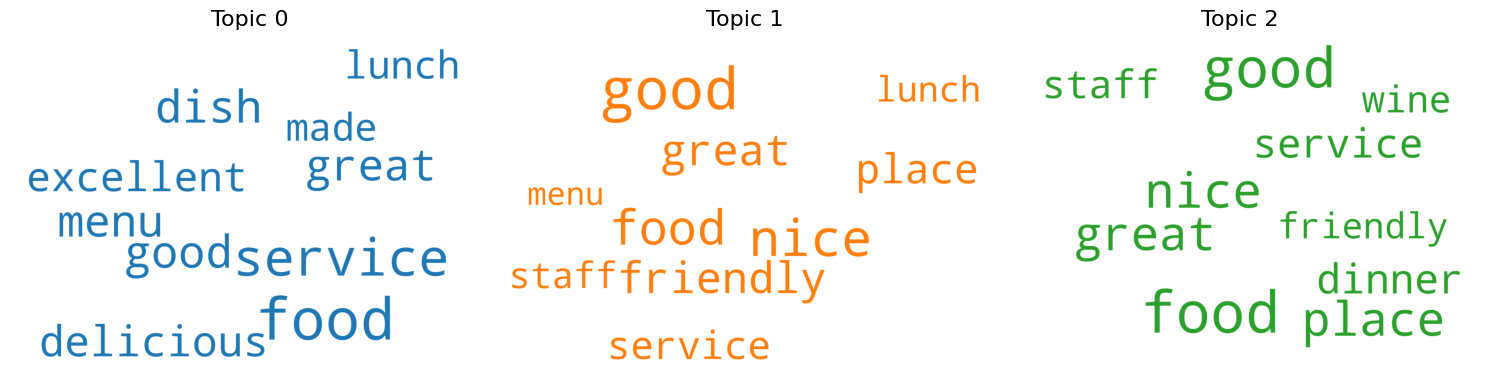

Figure 1: Topic modelling for file Dutch (positive)
[(0, '0.019*"food"'), (1, '0.017*"food"'), (2, '0.015*"service"')]


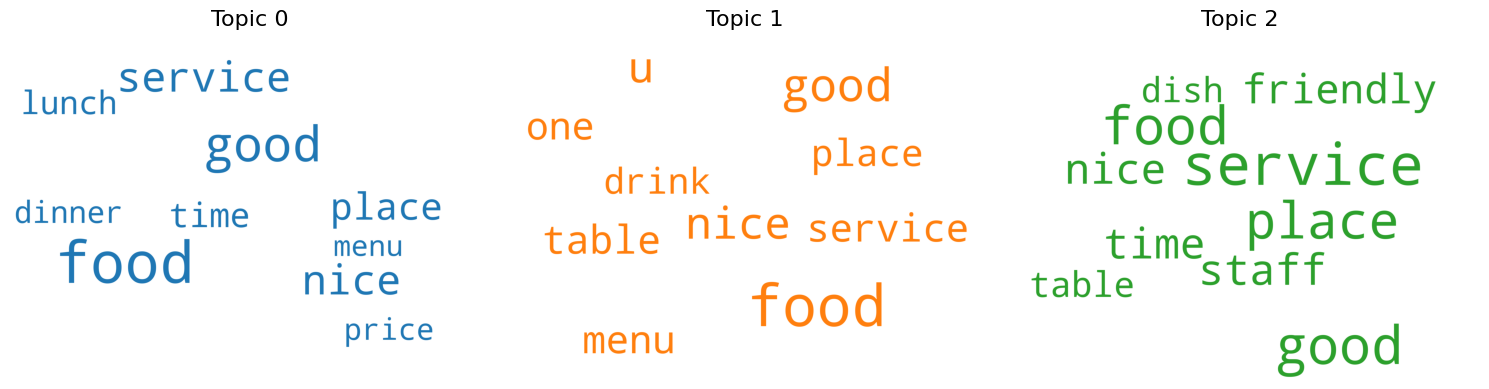

Figure 1: Topic modelling for file European (negative)
[(0, '0.014*"food"'), (1, '0.022*"place"'), (2, '0.031*"good"')]


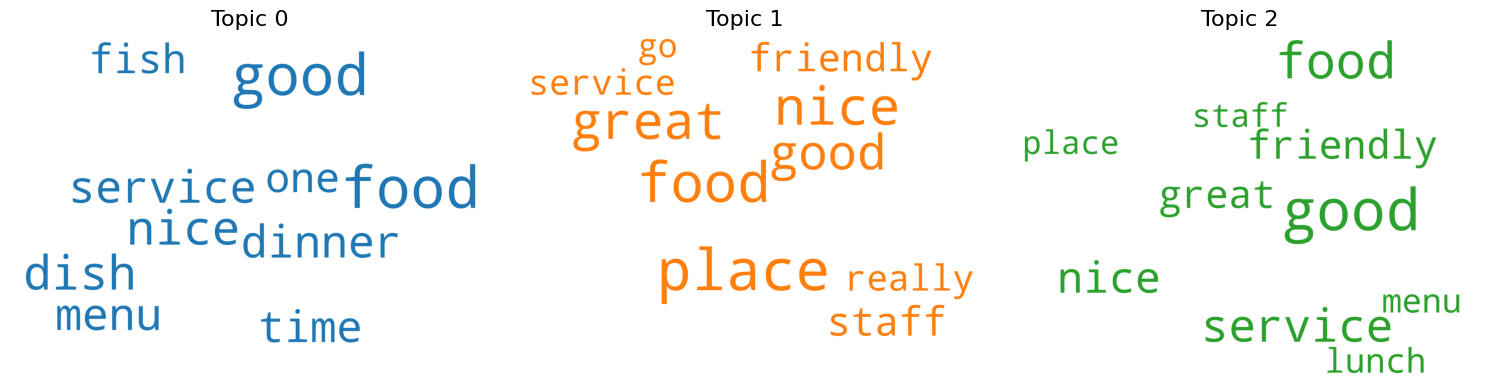

Figure 1: Topic modelling for file European (positive)
[(0, '0.011*"food"'), (1, '0.020*"food"'), (2, '0.023*"pizza"')]


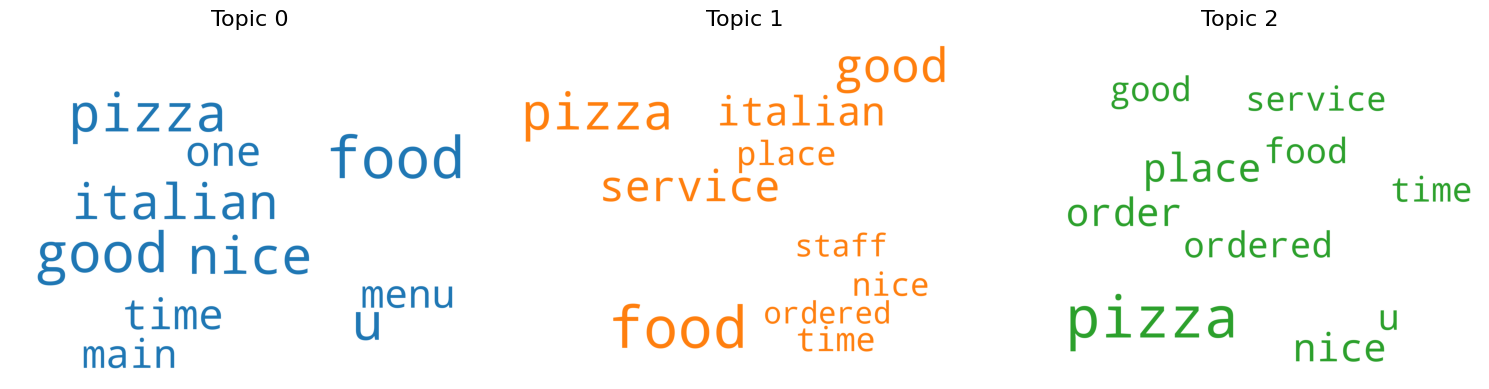

Figure 1: Topic modelling for file Italian (negative)
[(0, '0.027*"good"'), (1, '0.018*"italian"'), (2, '0.027*"pizza"')]


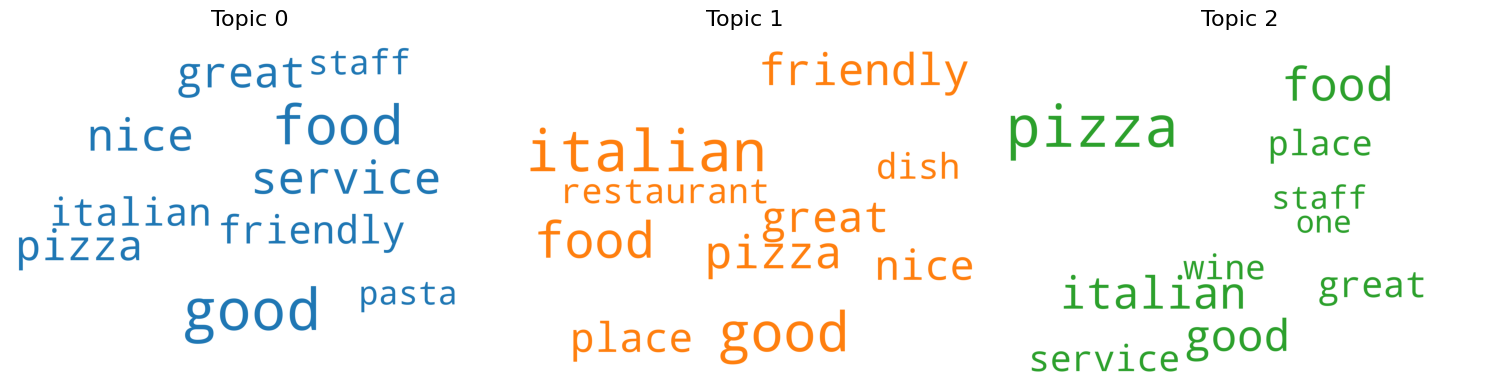

Figure 1: Topic modelling for file Italian (positive)
[(0, '0.015*"food"'), (1, '0.016*"food"'), (2, '0.021*"food"')]


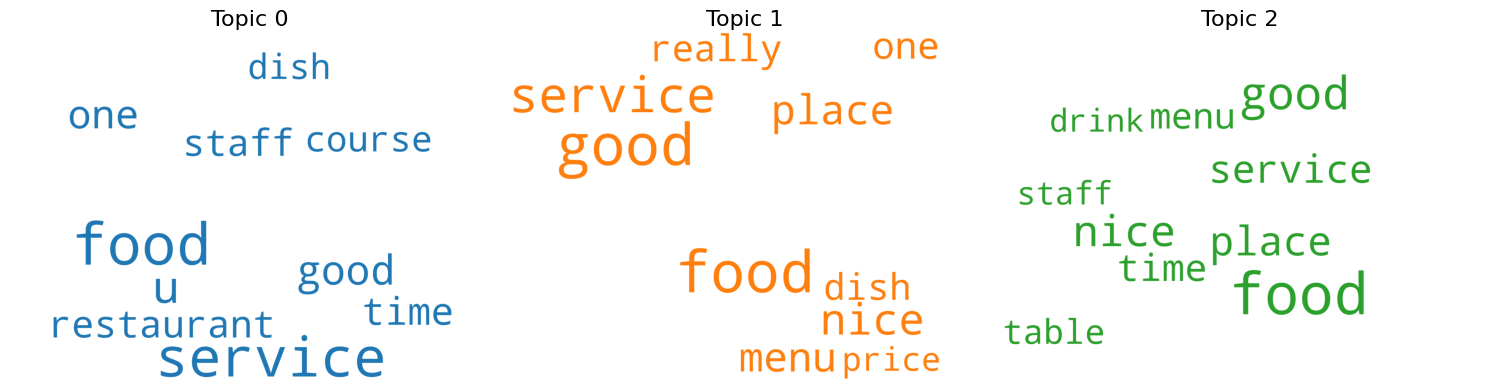

Figure 1: Topic modelling for file Seafood (negative)
[(0, '0.029*"food"'), (1, '0.015*"good"'), (2, '0.015*"good"')]


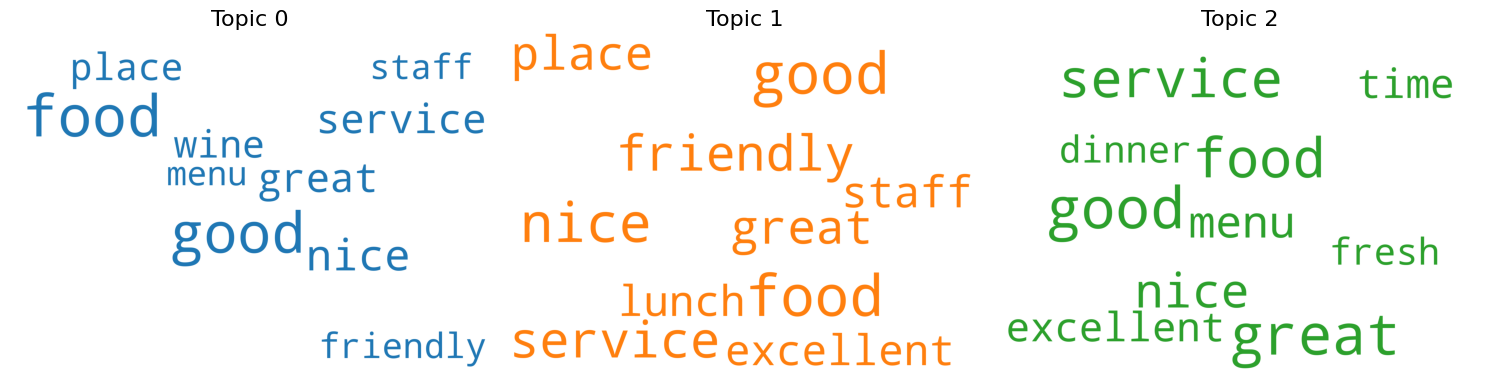

Figure 1: Topic modelling for file Seafood (positive)
[(0, '0.013*"good"'), (1, '0.020*"food"'), (2, '0.022*"food"')]


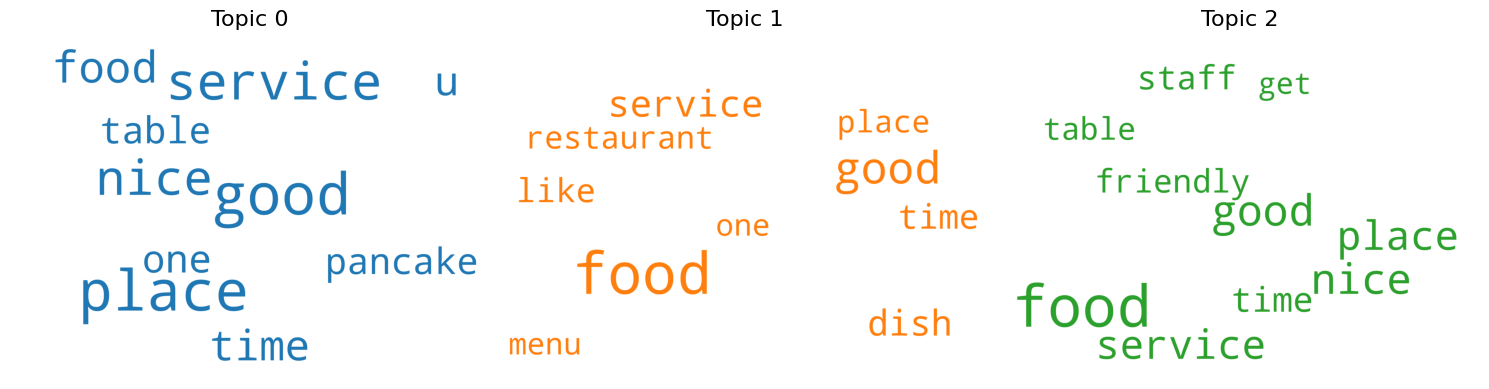

Figure 1: Topic modelling for file Vegetarian friendly (negative)
[(0, '0.013*"food"'), (1, '0.025*"good"'), (2, '0.021*"food"')]


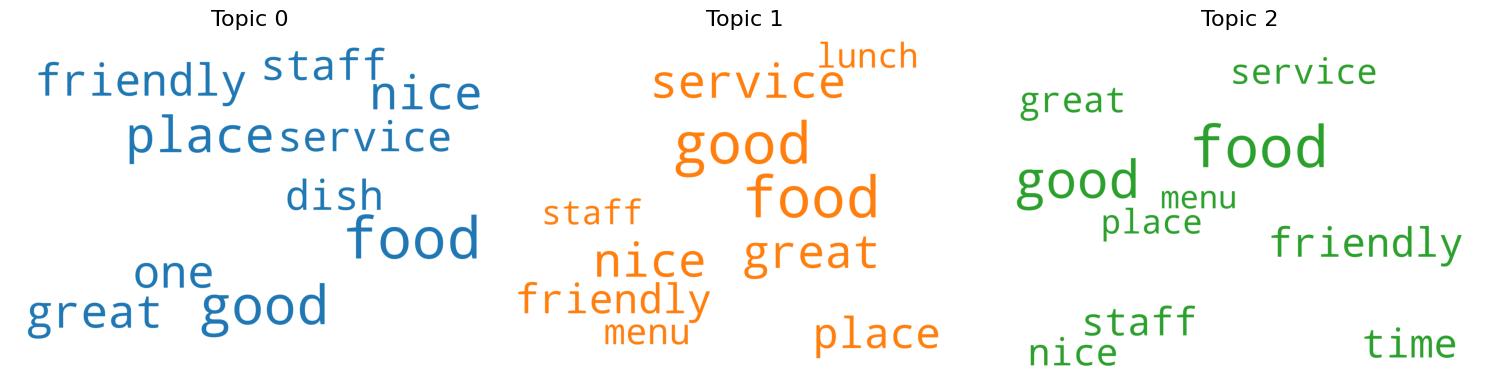

Figure 1: Topic modelling for file Vegetarian friendly (positive)


In [255]:
new_files = glob.glob(f'./{folder_name}/*')
for f in new_files:
    processed_reviews = read_and_preprocess_file(f)
    topic_modelling(processed_reviews, f)